In [1]:

import os
import cv2
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sn


In [4]:


# Define el directorio de la base de datos
directorio = r'C:\Users\joshu\Downloads\Dataset_Emotions\Dataset_Emotions\Images'

# Define el mapeo de emociones a etiquetas numéricas
emociones = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

# Cargar las imágenes y etiquetas
imagenes_data = []
etiquetas = []
for emocion, etiqueta in emociones.items():
    emocion_dir = os.path.join(directorio, emocion)
    for nombre_imagen in os.listdir(emocion_dir):
        ruta_imagen = os.path.join(emocion_dir, nombre_imagen)
        imagen_actual = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
        imagen_rgb = cv2.cvtColor(imagen_actual, cv2.COLOR_GRAY2RGB)
        imagen_rgb = imagen_rgb / 255.0  # Normalizar
        imagenes_data.append(imagen_rgb)
        etiquetas.append(etiqueta)

imagenes_data = np.array(imagenes_data)
etiquetas = np.array(etiquetas)

# Separar los datos en conjuntos de entrenamiento y validación
imagenes_train, imagenes_val, etiquetas_train, etiquetas_val = train_test_split(
    imagenes_data, etiquetas, test_size=0.2, random_state=42
)



In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, Input
import tensorflow as tf
# Configurar aumento de datos
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Ajustar el generador al conjunto de entrenamiento
datagen.fit(imagenes_train)

# Definir la entrada
input_shape = (600, 500, 3)  # Ajustar tamaño de entrada para reducir parámetros

# Construcción del modelo
model = models.Sequential()

# Primera capa convolucional con Depthwise separable para mantener eficiencia
model.add(layers.Conv2D(8, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(16, (1, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Segunda serie de capas convolucionales
model.add(layers.Conv2D(32, (1, 1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (1, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Bloque final con convoluciones y pooling global
model.add(layers.Conv2D(64, (1, 1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (1, 1), padding='same', activation='relu'))
model.add(layers.GlobalAveragePooling2D())

# Capas densas finales con Dropout y regularización
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.4))  # Dropout ajustado para reducir sobreajuste
model.add(layers.Dense(7, activation='softmax'))

# Compilación del modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Implementar EarlyStopping y reducción de learning rate en Plateau
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10)

# Entrenamiento del modelo
history = model.fit(datagen.flow(imagenes_train, etiquetas_train, batch_size=4),
                    validation_data=(imagenes_val, etiquetas_val),
                    epochs=400,
                    callbacks=[early_stopping, reduce_lr])

# Guardar el modelo entrenado
model.save('modelo_ajustado.h5')

# Visualización del resumen del modelo
model.summary()


Epoch 1/400
78/78 [==============================] - 13s 147ms/step - loss: 2.4590 - accuracy: 0.1731 - val_loss: 2.3386 - val_accuracy: 0.2436 - lr: 1.0000e-04
Epoch 2/400
78/78 [==============================] - 11s 144ms/step - loss: 2.2384 - accuracy: 0.2821 - val_loss: 2.2901 - val_accuracy: 0.2436 - lr: 1.0000e-04
Epoch 3/400
78/78 [==============================] - 11s 142ms/step - loss: 2.0890 - accuracy: 0.3237 - val_loss: 2.2152 - val_accuracy: 0.2436 - lr: 1.0000e-04
Epoch 4/400
78/78 [==============================] - 11s 140ms/step - loss: 1.9607 - accuracy: 0.3429 - val_loss: 2.1228 - val_accuracy: 0.2436 - lr: 1.0000e-04
Epoch 5/400
78/78 [==============================] - 11s 140ms/step - loss: 1.8080 - accuracy: 0.3365 - val_loss: 2.0057 - val_accuracy: 0.2436 - lr: 1.0000e-04
Epoch 6/400
78/78 [==============================] - 11s 142ms/step - loss: 1.7332 - accuracy: 0.2853 - val_loss: 1.8537 - val_accuracy: 0.3718 - lr: 1.0000e-04
Epoch 7/400
78/78 [===============

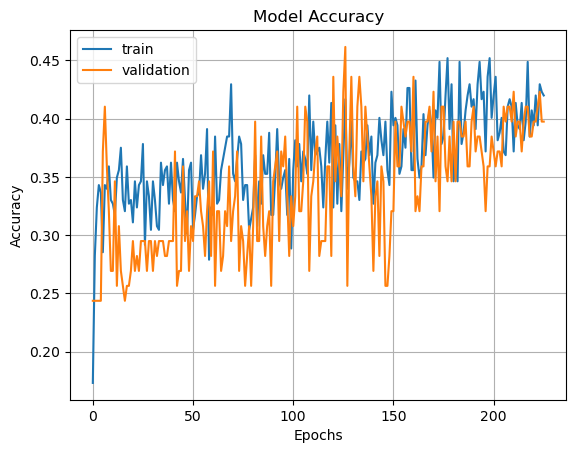

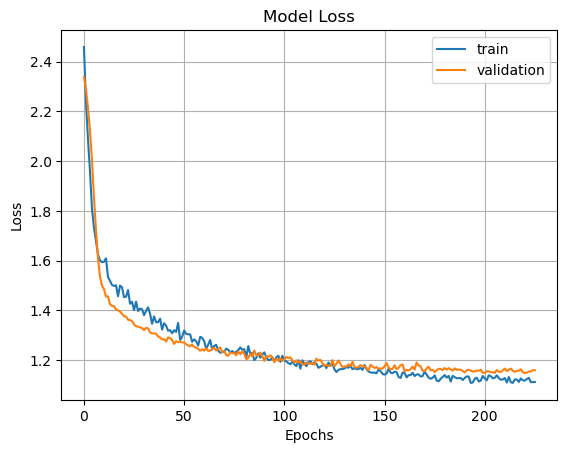

3/3 [==============================] - 0s 71ms/step
              precision    recall  f1-score   support

    Negative     0.4444    0.2286    0.3019        35
     Neutral     0.3333    0.6842    0.4483        19
    Positive     0.5238    0.4583    0.4889        24

    accuracy                         0.4103        78
   macro avg     0.4339    0.4570    0.4130        78
weighted avg     0.4418    0.4103    0.3951        78



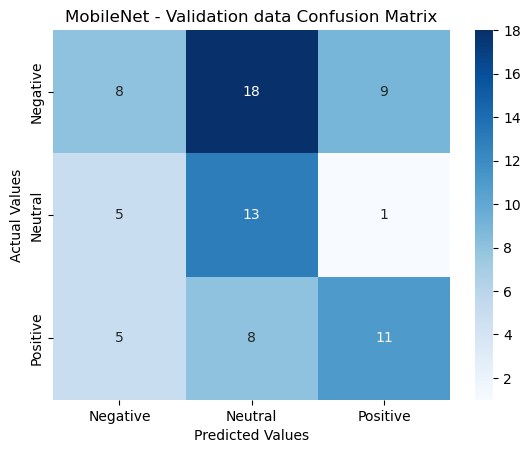

In [7]:

# Evaluar y graficar los resultados
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Realizar predicciones con el modelo
y_pred = model.predict(imagenes_val)
y_pred_clases = np.argmax(y_pred, axis=1)

# Calcular métricas de evaluación
acc_val = accuracy_score(etiquetas_val, y_pred_clases)

# Matriz de confusión de validación
matriz_confusion_val = confusion_matrix(etiquetas_val, y_pred_clases)

# Visualizar la matriz de confusión
plt.figure()
ax = sn.heatmap(matriz_confusion_val, annot=True, cmap='Blues')
ax.set_title('MobileNet - Validation data Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Ajustar los labels de los ticks
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])

plt.savefig('MobileNet_confusion_matrix.png')

# Informe de clasificación
target_names = ['Negative', 'Neutral', 'Positive']
report = classification_report(etiquetas_val, y_pred_clases, digits=4, target_names=target_names)
print(report)

